In [1]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
! pip install gym
from gym import Env
from gym.spaces import Discrete, Box


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
class RL_env(Env):
    def __init__(self):
        self.grid_size = 5
        self.state_space = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        self.action_space = Discrete(4)  # Actions => 0=Up, 1=Right, 2=Down, 3=Left
        self.observation_space = Box(low=0, high=self.grid_size-1, shape=(2,), dtype=int)

        self.rewards = {
            (0, 2): -5,
            (2, 3): -6,
            (2, 1): +5,
            (4, 2): +7,
            (4, 4): +10
        }

        self.state = (0, 0)
        self.goal_state = (4, 4)

    def reset(self):
        self.state = (0, 0)
        return np.array(self.state, dtype=int)

    def step(self, action):
        row, col = self.state
        if action == 0 and row > 0:         # Up
            row -= 1
        elif action == 1 and col < self.grid_size - 1:  # Right
            col += 1
        elif action == 2 and row < self.grid_size - 1:  # Down
            row += 1
        elif action == 3 and col > 0:       # Left
            col -= 1
        self.state = (row, col)
        reward = self.rewards.get(self.state, 0)
        done = self.state == self.goal_state
        return np.array(self.state, dtype=int), reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        for position, reward in self.rewards.items():
            grid[position] = reward
        grid[self.state] = 1  # Marking position of agent
        plt.imshow(grid, cmap='coolwarm', origin='upper')
        plt.colorbar()
        plt.show()

In [ ]:
class NStepDoubleQLearningAgent:
    def __init__(self, env, n=1, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.n = n
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table1 = self.init_q_table()
        self.q_table2 = self.init_q_table()

    def init_q_table(self):
        return np.zeros((self.env.grid_size, self.env.grid_size, self.env.action_space.n))

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        row, col = state
        q_values = self.q_table1[row, col] + self.q_table2[row, col]
        return np.argmax(q_values)

    def train(self, num_episodes=500, max_timesteps=100):
        rewards_per_episode = []
        epsilon_values = []
        initial_q_table1 = np.copy(self.q_table1)
        initial_q_table2 = np.copy(self.q_table2)

        for episode in range(num_episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            transitions = deque(maxlen=self.n)

            for t in range(max_timesteps):
                next_state, reward, done, _ = self.env.step(action)
                next_action = self.choose_action(next_state)
                transitions.append((state, action, reward))

                if len(transitions) == self.n or done:
                    G = sum([self.gamma ** i * transitions[i][2] for i in range(len(transitions))])
                    if not done:
                        row, col = next_state
                        next_q_max = max(self.q_table1[row, col]) if random.random() < 0.5 else max(self.q_table2[row, col])
                        G += self.gamma ** self.n * next_q_max

                    # Update the Q-table
                    s, a, _ = transitions[0]
                    row, col = s
                    if random.random() < 0.5:
                        self.q_table1[row, col, a] += self.alpha * (G - self.q_table1[row, col, a])
                    else:
                        self.q_table2[row, col, a] += self.alpha * (G - self.q_table2[row, col, a])

                state, action = next_state, next_action
                total_reward += reward
                if done:
                    break

            rewards_per_episode.append(total_reward)
            epsilon_values.append(self.epsilon)
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        return rewards_per_episode, epsilon_values, initial_q_table1, initial_q_table2

    def evaluate_greedy_policy(self, num_episodes=10, max_timesteps=100):
        rewards_per_episode = []
        for _ in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            for _ in range(max_timesteps):
                row, col = state
                q_values = self.q_table1[row, col] + self.q_table2[row, col]
                action = np.argmax(q_values)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward
                if done:
                    break
            rewards_per_episode.append(total_reward)
        return rewards_per_episode

Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=500, max_timesteps=50
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=500, max_timesteps=100
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=500, max_timesteps=150
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000, max_timesteps=50
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000, max_timesteps=100
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1000, max_timesteps=150
Average Greedy Reward: 670.0
Training with parameters: gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01, num_episodes=1500, max_timesteps=50
Average Greedy Reward: 670.0
Training wit

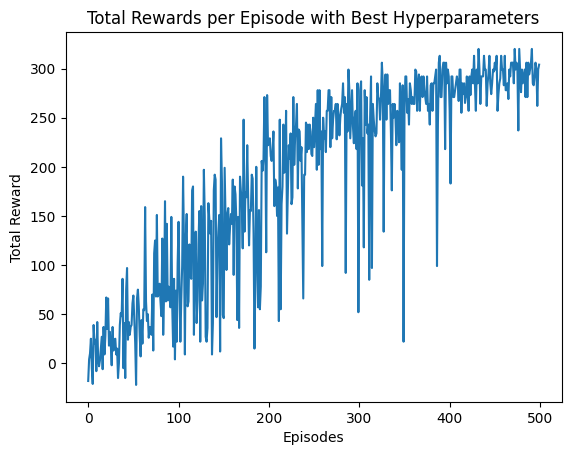

In [ ]:
# Hyperparameter optimization
def optimize_hyperparameters():
    gamma_values = [0.9, 0.95, 0.99]
    epsilon_decay_values = [0.995, 0.99, 0.98]
    epsilon_min_values = [0.01, 0.05, 0.1]
    num_episodes_values = [500, 1000, 1500]
    max_timesteps_values = [50, 100, 150]

    best_reward = -float('inf')
    best_params = None
    best_results = None
    for gamma in gamma_values:
        for epsilon_decay in epsilon_decay_values:
            for epsilon_min in epsilon_min_values:
                for num_episodes in num_episodes_values:
                    for max_timesteps in max_timesteps_values:
                        print(f"Training with parameters: gamma={gamma}, epsilon_decay={epsilon_decay}, epsilon_min={epsilon_min}, "
                              f"num_episodes={num_episodes}, max_timesteps={max_timesteps}")
                            
                        env = RL_env()
                        agent = NStepDoubleQLearningAgent(env, n=3, alpha=0.1, gamma=gamma, epsilon=1.0, 
                                                          epsilon_decay=epsilon_decay, epsilon_min=epsilon_min)
                        rewards, _, _, _ = agent.train(num_episodes=num_episodes, max_timesteps=max_timesteps)
                        greedy_rewards = agent.evaluate_greedy_policy(num_episodes=10)
                        avg_reward = np.mean(greedy_rewards)
                        print(f"Average Greedy Reward: {avg_reward}")
                        if avg_reward > best_reward:
                            best_reward = avg_reward
                            best_params = (gamma, epsilon_decay, epsilon_min, num_episodes, max_timesteps)
                            best_results = rewards

    print(f"Best Hyperparameters: gamma={best_params[0]}, epsilon_decay={best_params[1]}, epsilon_min={best_params[2]}, "
          f"num_episodes={best_params[3]}, max_timesteps={best_params[4]}")
    plt.plot(best_results)
    plt.title(f"Total Rewards per Episode with Best Hyperparameters")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.show()

optimize_hyperparameters()

### Best Hyperparameters: 
gamma=0.9

epsilon_decay=0.995

epsilon_min=0.01

num_episodes=500

max_timesteps=50

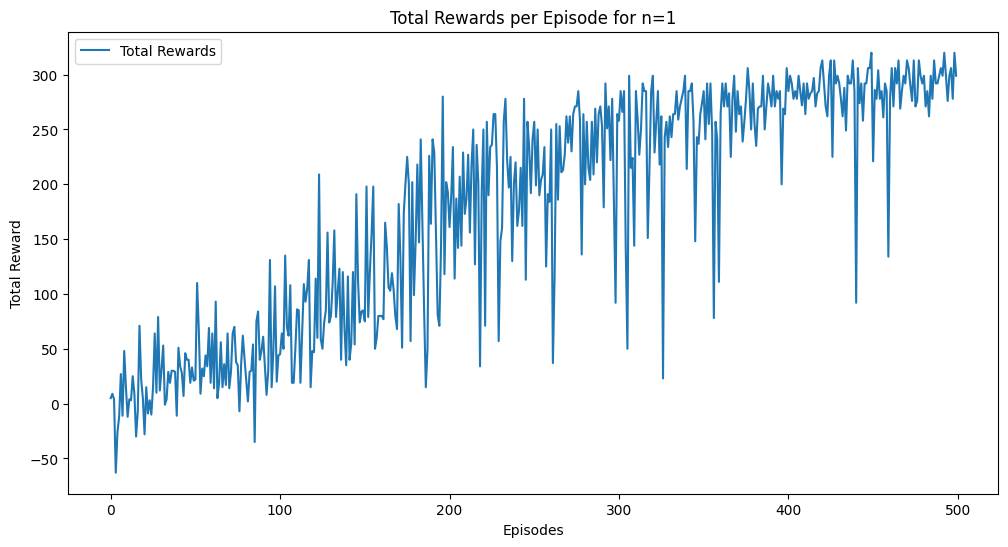

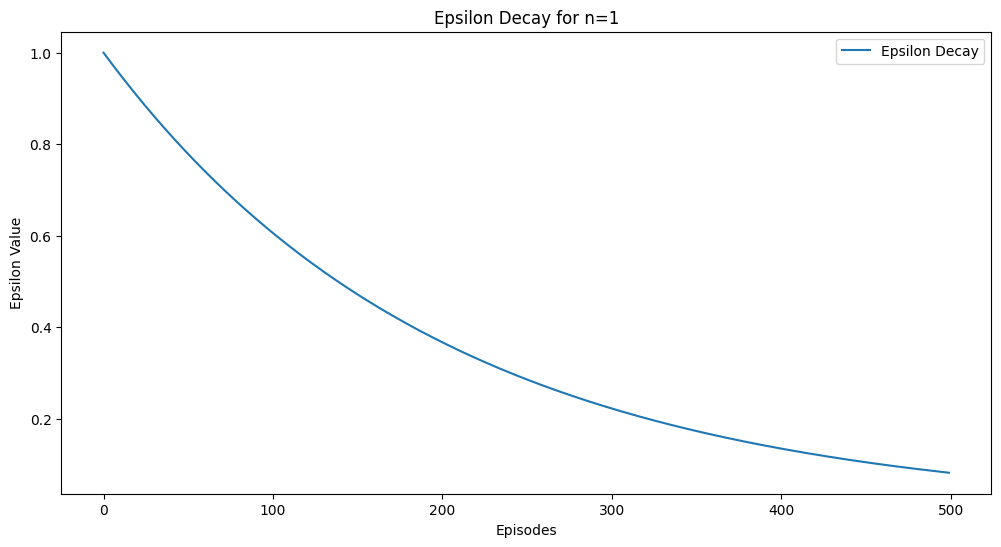

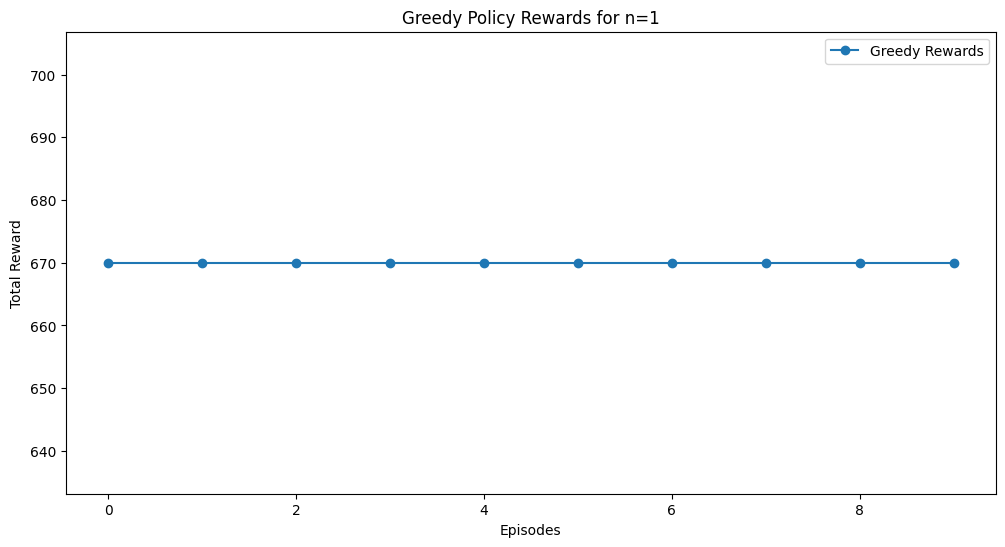

n=1, Average Greedy Reward: 670.0
Initial Q-table for n=1 (Q1):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Initial Q-table for n=1 (Q2):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Trained Q-table for n=1 (Q1):
[[[ 2.86942796e+01  2.01672589e+01  4.53827102e+01  1.97

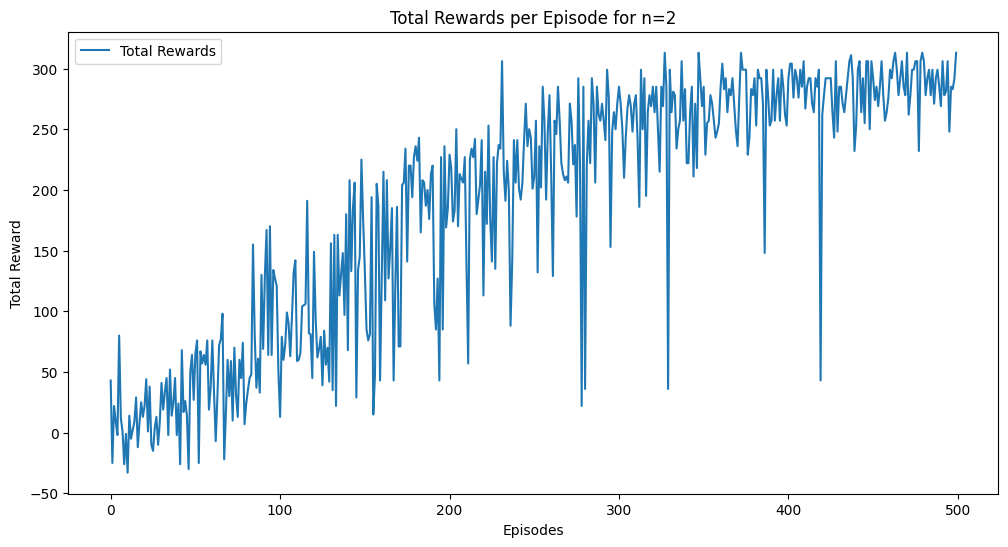

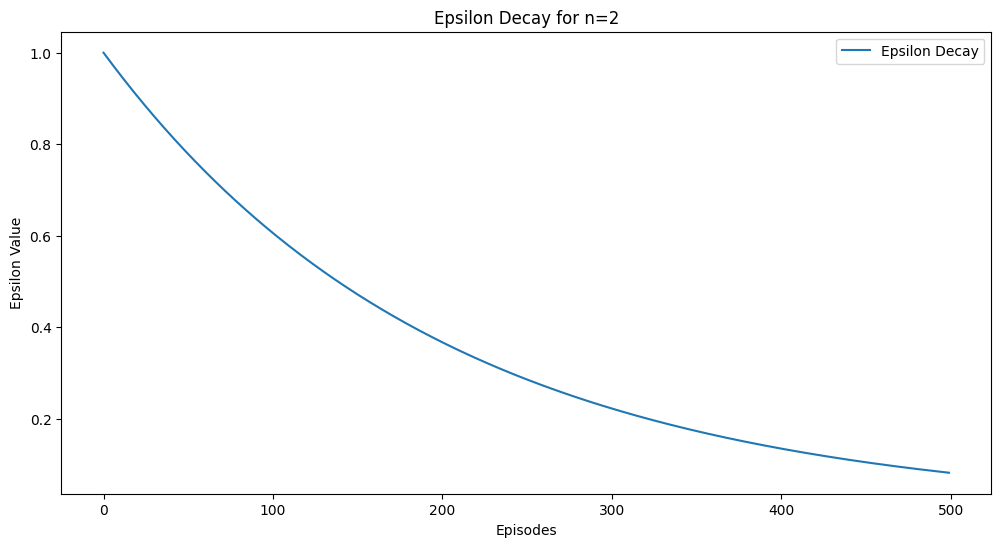

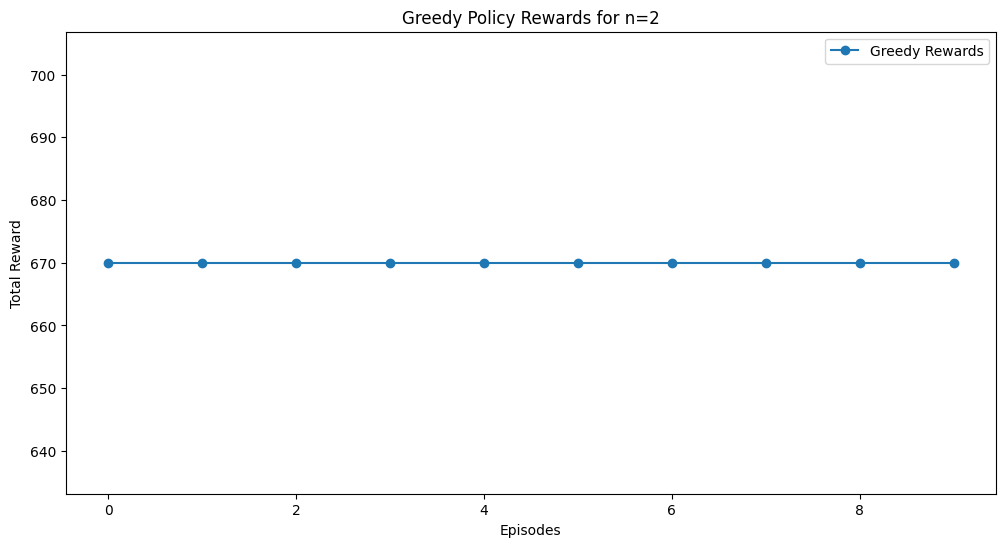

n=2, Average Greedy Reward: 670.0
Initial Q-table for n=2 (Q1):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Initial Q-table for n=2 (Q2):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Trained Q-table for n=2 (Q1):
[[[ 2.37555208e+01  2.23749375e+01  4.16763412e+01  2.61

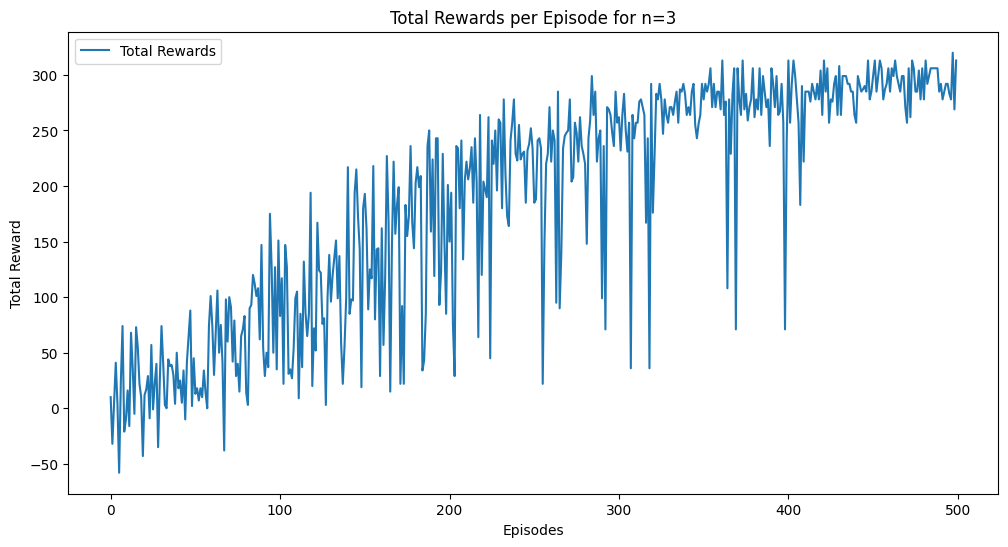

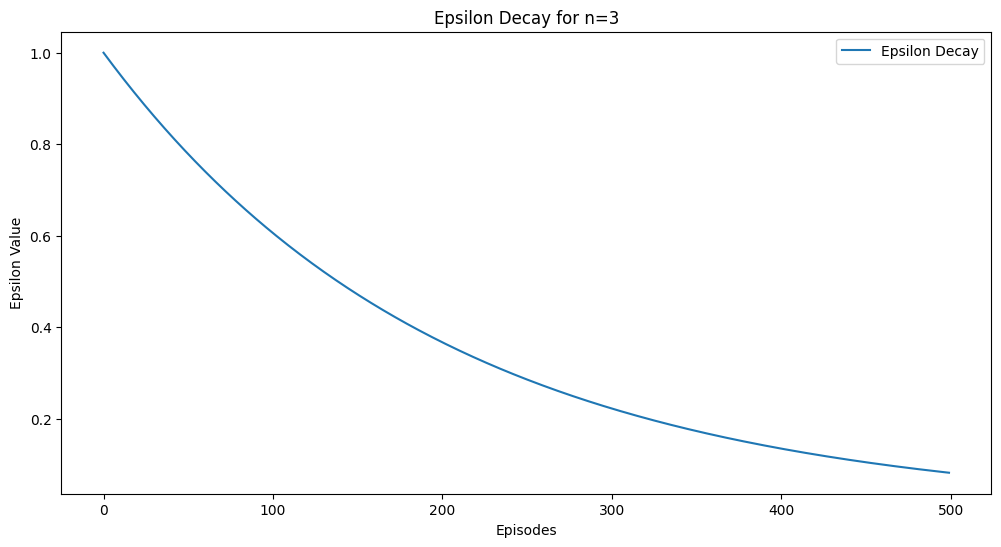

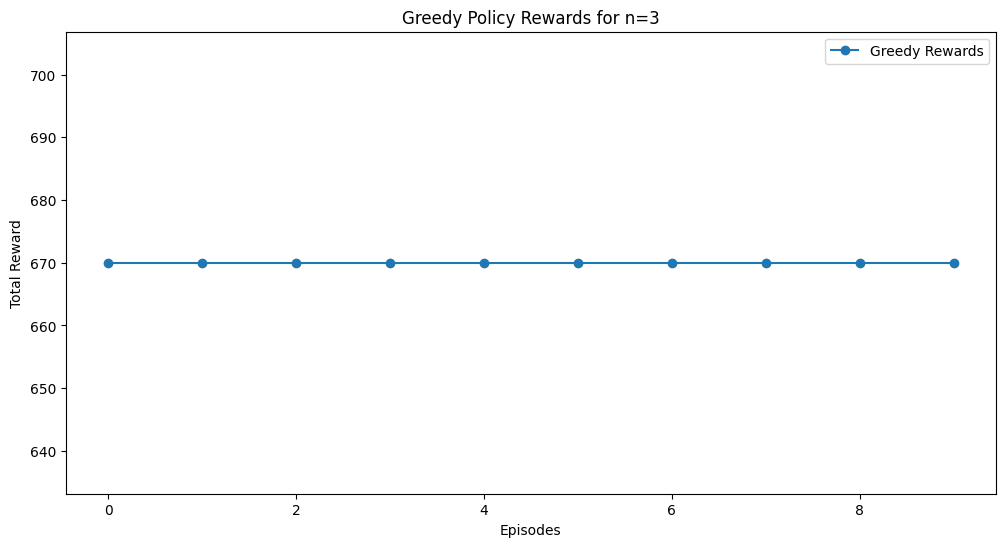

n=3, Average Greedy Reward: 670.0
Initial Q-table for n=3 (Q1):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Initial Q-table for n=3 (Q2):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Trained Q-table for n=3 (Q1):
[[[ 2.71091683e+01  2.60019301e+01  4.11919908e+01  2.24

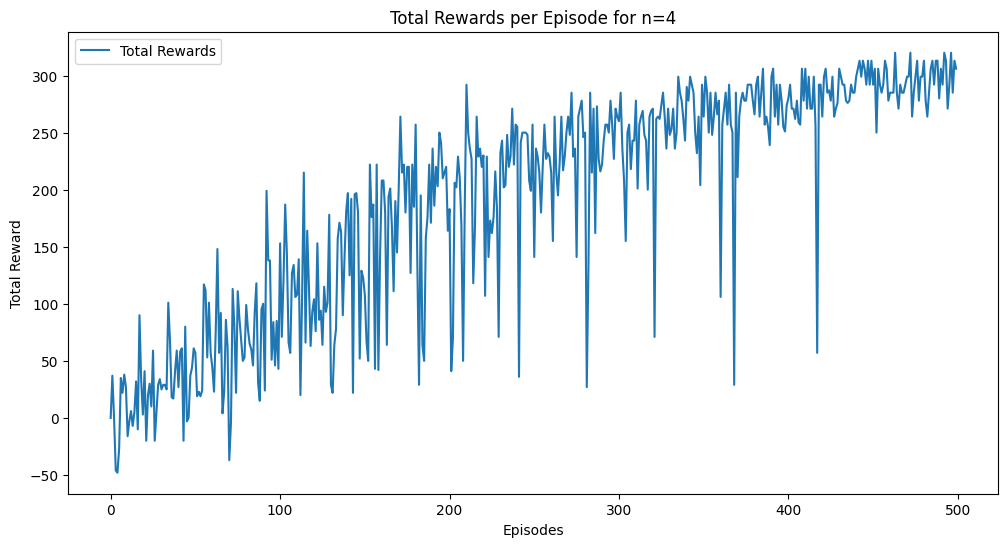

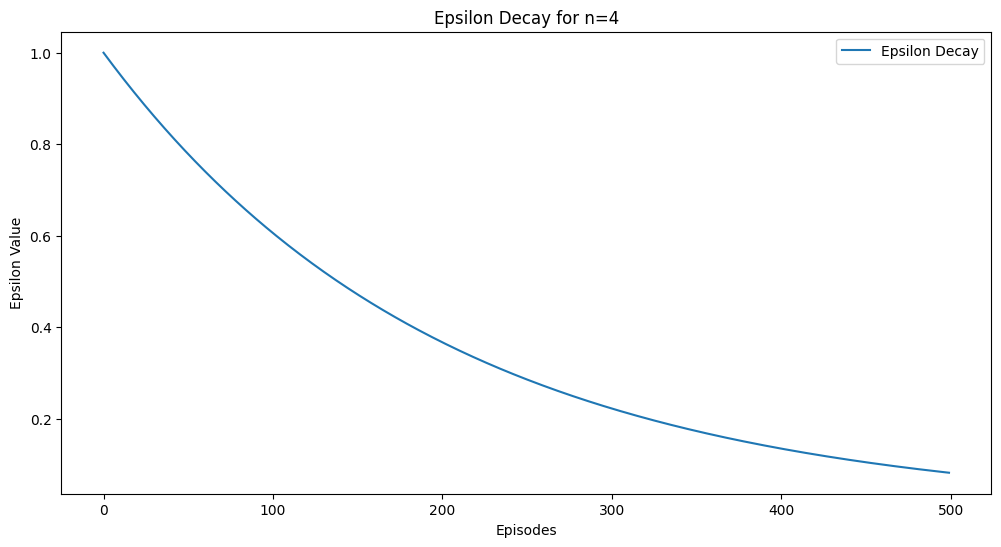

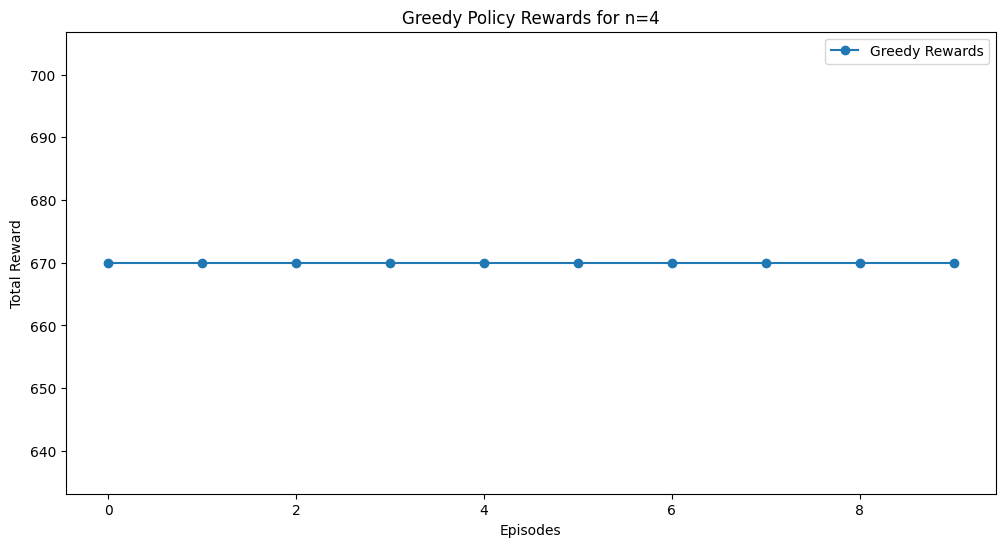

n=4, Average Greedy Reward: 670.0
Initial Q-table for n=4 (Q1):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Initial Q-table for n=4 (Q2):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Trained Q-table for n=4 (Q1):
[[[ 2.62665427e+01  2.35083778e+01  4.09289842e+01  2.49

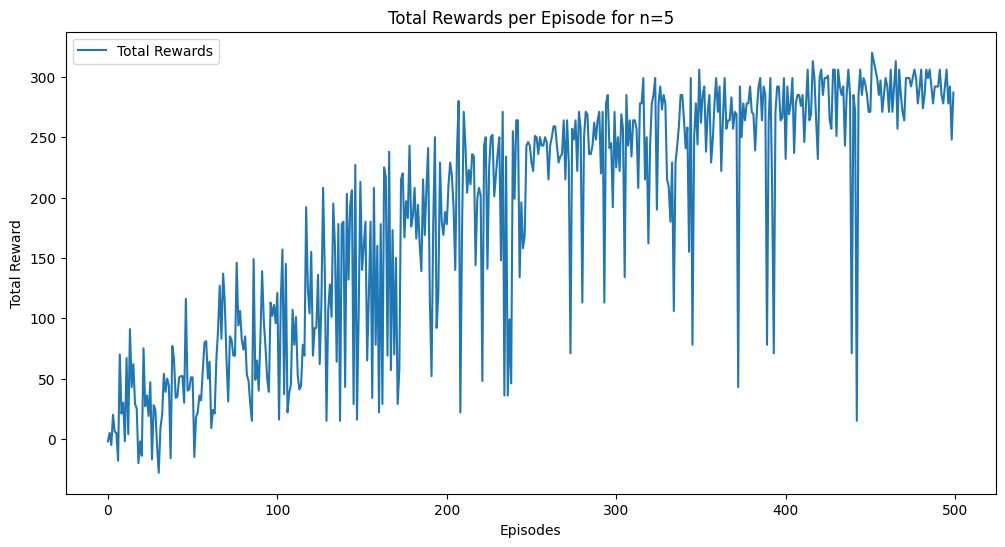

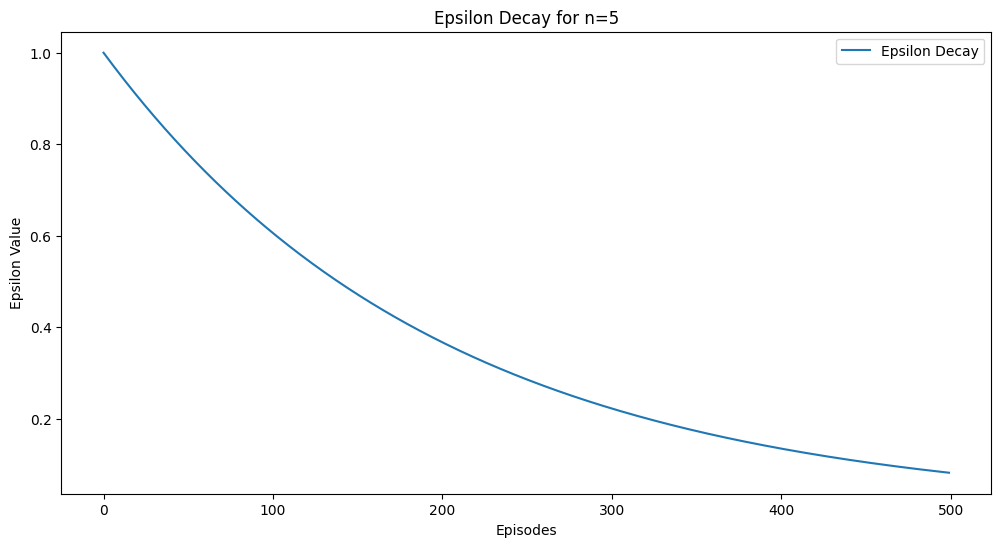

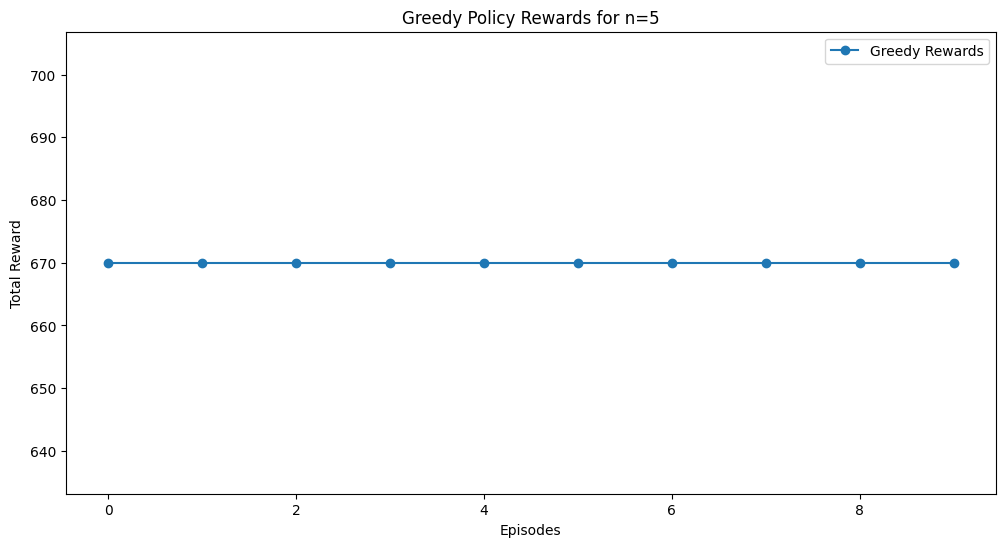

n=5, Average Greedy Reward: 670.0
Initial Q-table for n=5 (Q1):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Initial Q-table for n=5 (Q2):
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
Trained Q-table for n=5 (Q1):
[[[23.11909147 25.91106862 40.92038181 22.94374029]
  [ 

In [ ]:
# Running the model with best hyperparameters for different n values
env = RL_env()
results = {}

for n in range(1, 6):
    agent = NStepDoubleQLearningAgent(env, n=n, gamma=0.9, epsilon_decay=0.995, epsilon_min=0.01)
    rewards, epsilons, q1_initial, q2_initial = agent.train(num_episodes=500, max_timesteps=50)
    greedy_rewards = agent.evaluate_greedy_policy(num_episodes=10)

    results[n] = {
        "rewards": rewards,
        "epsilons": epsilons,
        "q1_initial": q1_initial,
        "q2_initial": q2_initial,
        "greedy_rewards": greedy_rewards,
        "q_table1": agent.q_table1,
        "q_table2": agent.q_table2,
    }

    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label="Total Rewards")
    plt.title(f"Total Rewards per Episode for n={n}")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(epsilons, label="Epsilon Decay")
    plt.title(f"Epsilon Decay for n={n}")
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon Value")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(greedy_rewards, label="Greedy Rewards", marker='o')
    plt.title(f"Greedy Policy Rewards for n={n}")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.show()

    print(f"n={n}, Average Greedy Reward: {np.mean(greedy_rewards)}")
    print(f"Initial Q-table for n={n} (Q1):")
    print(q1_initial)
    print(f"Initial Q-table for n={n} (Q2):")
    print(q2_initial)
    print(f"Trained Q-table for n={n} (Q1):")
    print(agent.q_table1)
    print(f"Trained Q-table for n={n} (Q2):")
    print(agent.q_table2)